In [85]:
import sys
sys.path.append("../") 

In [86]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, data_home='../data',cache=True,as_frame=False)
X=X/255.

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

In [88]:
import numpy as np
from hamiltonian import utils

num_examples,num_inputs=X_train.shape
num_outputs=len(np.unique(y_train))

#y_train=utils.one_hot(y_train,num_outputs)
#y_test=utils.one_hot(y_test,num_outputs)

In [89]:
y_train=np.int32(y_train)
y_test=np.int32(y_test)

In [136]:

import mxnet as mx
from mxnet import nd, autograd, gluon


model_ctx=mx.cpu()
par={'weights':nd.random_normal(shape=(num_inputs,num_outputs),ctx=model_ctx),'bias':nd.random_normal(shape=num_outputs,ctx=model_ctx)}
hyper={'alpha':100.}

In [107]:
from hamiltonian.inference.sgd import sgd
from hamiltonian.models.softmax import softmax

model=softmax(hyper,ctx=model_ctx)
inference=sgd(model,par,step_size=0.05,ctx=model_ctx)

In [91]:
import importlib
import hamiltonian
importlib.reload(hamiltonian.models.softmax)
importlib.reload(hamiltonian.inference.sgd)

<module 'hamiltonian.inference.sgd' from '../hamiltonian/inference/sgd.py'>

In [116]:
par,loss=inference.fit(epochs=100,batch_size=64,X_train=X_train,y_train=y_train,verbose=False)

100%|██████████| 100/100 [02:39<00:00,  1.59s/it]


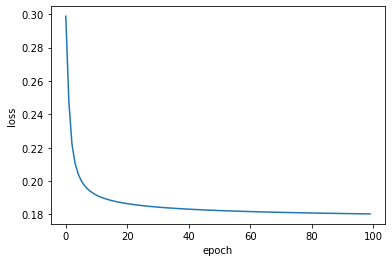

In [117]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [120]:
y_pred=model.predict(par,nd.array(X_test,ctx=model_ctx))

In [121]:
samples=[]
for _ in range(100):
    samples.append(y_pred.sample().asnumpy())

In [122]:
samples=np.asarray(samples)

In [123]:
samples.shape

(100, 14000)

In [124]:
y_hat=np.quantile(samples,.5,axis=0)

In [125]:
from sklearn.metrics import classification_report

print(classification_report(y_test,np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1409
           1       0.94      0.96      0.95      1540
           2       0.87      0.87      0.87      1372
           3       0.86      0.84      0.85      1382
           4       0.90      0.88      0.89      1389
           5       0.82      0.83      0.83      1348
           6       0.91      0.94      0.93      1340
           7       0.89      0.90      0.90      1427
           8       0.84      0.83      0.83      1377
           9       0.85      0.85      0.85      1416

    accuracy                           0.89     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.89      0.89      0.89     14000



In [101]:
X_batch=nd.array(X_train[:32])
y_batch=nd.array(y_train[:32])

In [126]:
like=model.negative_log_likelihood(par,X_train=X_batch,y_train=y_batch)
prior=model.negative_log_prior(par)

In [127]:
like


[0.10164087]
<NDArray 1 @cpu(0)>

In [128]:
prior


[11.048315]
<NDArray 1 @cpu(0)>

In [139]:
par_gluon={'weights':mx.gluon.Parameter('weight', shape=(num_inputs, num_outputs)),
           'bias':mx.gluon.Parameter('bias', shape=(num_outputs,))}

for key in par_gluon:
    par_gluon[key].initialize(ctx=model_ctx)

In [144]:
for key in par_gluon:
    par_gluon[key].data()

In [145]:
model.negative_log_prior(par)


[11.048339]
<NDArray 1 @cpu(0)>

In [152]:
type(par_gluon[key]) is mx.gluon.parameter.Parameter

True

In [153]:
from mxnet import gluon

In [170]:
trainer = gluon.Trainer(par_gluon, 'sgld',
                            {'learning_rate': 0.05})

In [171]:
isinstance(par_gluon['weights'], gluon.parameter.Parameter)

True

In [175]:
sgd = mx.optimizer.Optimizer.create_optimizer('sgd')

In [174]:
sgd.step()


[[ 0.02129744 -0.00103146  0.04945444 ... -0.06073099 -0.03281144
  -0.06805889]
 [-0.06810878  0.05763195 -0.0022746  ... -0.00666415 -0.03741182
  -0.04191073]
 [-0.02651191  0.06012652  0.04077184 ... -0.05715807  0.02869273
  -0.03790135]
 ...
 [ 0.00548165  0.01252234  0.05150874 ...  0.0488046  -0.03665862
   0.01697758]
 [ 0.01064675 -0.00897992 -0.02291542 ... -0.04030909 -0.04959077
  -0.02207062]
 [-0.03075904 -0.03097798 -0.0647708  ...  0.04539059  0.00363075
   0.04222263]]
<NDArray 784x10 @cpu(0)>